<a href="https://colab.research.google.com/github/sandalis05/Novelty-by-Newron/blob/main/Fridge_Item_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving Banana-Trainer.csv to Banana-Trainer.csv


In [5]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt
%matplotlib inline
import csv
%cd /content/
import io
df2 = pd.read_csv(io.BytesIO(uploaded['Banana-Trainer.csv']))
# Dataset is now stored in a Pandas Dataframe
print(df2)

/content
              Name  Classes  bb_coord1  bb_coord2  bb_coord3  bb_coord4
0   Banana_001.jpg        1   0.258621   0.410920   0.212644   0.218391
1   Banana_002.jpg        1   0.149425   0.708333   0.264368   0.566092
2   Banana_003.jpg        1   0.387931   0.209770   0.419540   0.183908
3   Banana_004.jpg        1   0.281609   0.158046   0.143678   0.114943
4   Banana_005.jpg        1   0.349138   0.173851   0.267241   0.272989
5   Banana_006.jpg        1   0.248563   0.577586   0.307471   0.362069
6   Banana_007.jpg        1   0.489943   0.600575   0.192529   0.454023
7   Banana_008.jpg        1   0.255747   0.428161   0.465517   0.385057
8   Banana_009.jpg        1   0.829023   0.311782   0.112069   0.181034
9   Banana_010.jpg        1   0.691092   0.244253   0.244253   0.178161
10  Banana_011.jpg        1   0.127874   0.877874   0.250000   0.221264
11  Banana_012.jpg        1   0.790230   0.191092   0.275862   0.336207
12  Banana_013.jpg        1   0.451149   0.581897   0.2

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       45 non-null     object 
 1   Classes    45 non-null     int64  
 2   bb_coord1  45 non-null     float64
 3   bb_coord2  45 non-null     float64
 4   bb_coord3  45 non-null     float64
 5   bb_coord4  45 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.2+ KB


In [7]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.5.0
The following GPU devices are available: /device:GPU:0


In [8]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)
  
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                                ymin,
                                xmin,
                                ymax,
                                xmax,
                                color,
                                font,
                                thickness=4,
                                display_str_list=()):  
      draw = ImageDraw.Draw(image)
      im_width, im_height = image.size
      (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                    ymin * im_height, ymax * im_height)
      draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                  (left, top)],
                width=thickness,
                fill=color)
# If the total height of the display strings added to the top of the bounding
# box exceeds the top of the image, stack the strings below the bounding box
# instead of above.
      display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
# Each display_str has a top and bottom margin of 0.05x.
      total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

      if top > total_display_str_height:
        text_bottom = top
      else:
        text_bottom = top + total_display_str_height
      # Reverse list and print from bottom to top.
      for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                        fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

  
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpyevvg6l0.jpg.


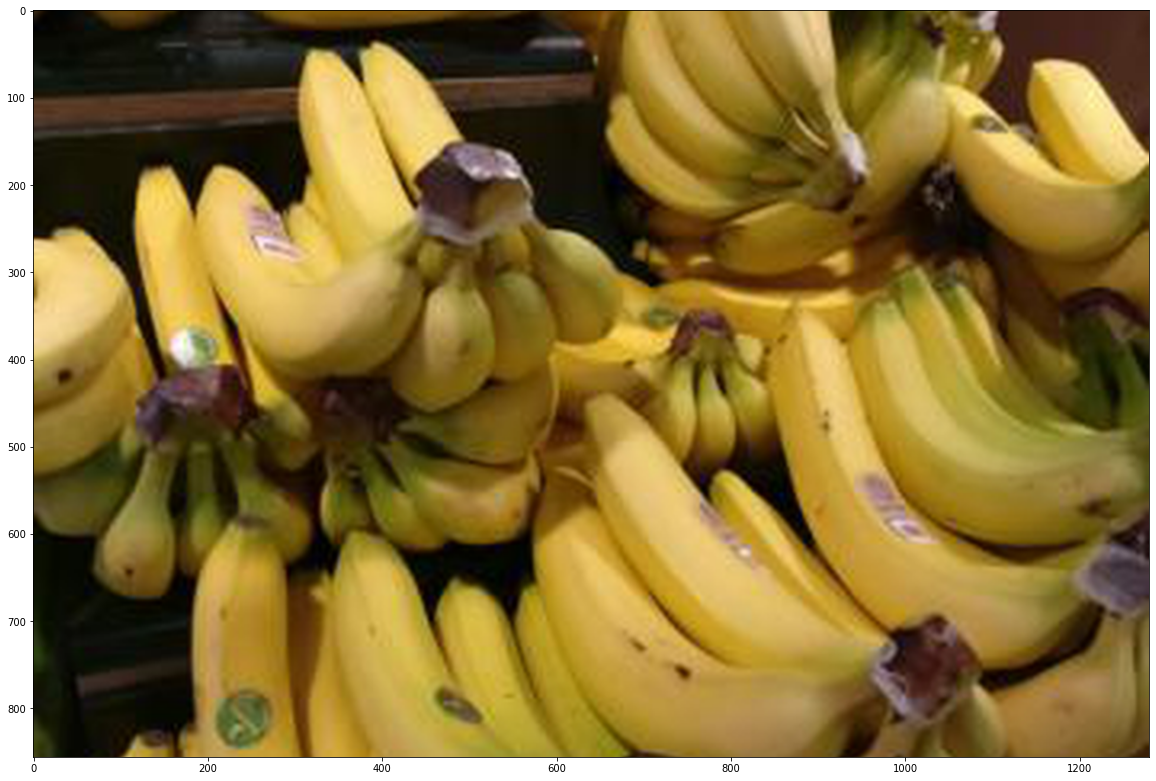

In [9]:
image_url = "https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/master/dataset/train/Fruit/Banana/Banana_001.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [10]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [11]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [12]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  57.05491280555725


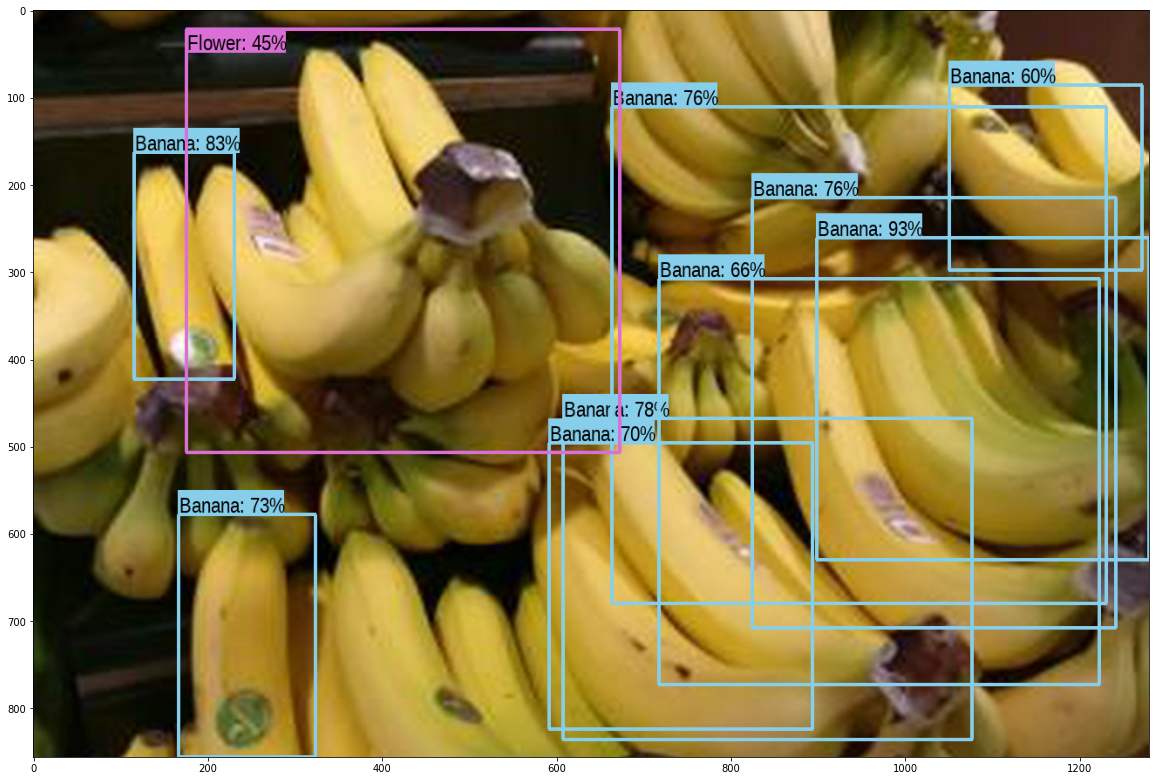

In [13]:
run_detector(detector, downloaded_image_path)

In [24]:
image_urls = [ "https://www.whirlpool.com/is/image/content/dam/business-unit/whirlpool/en-us/marketing-content/site-assets/page-content/refrigerator-sclp/Images/featuresassets/Side_By_Side_WRS588FIHZ_Full.png?fit=constrain&fmt=jpg&utc=2018-08-23T21:29:06Z&wid=1186",
              "https://www.bchydro.com/content/dam/BCHydro/customer-portal/photographs/objects-products/food-beverages/open-fridge-fullwidth-object.jpg",
              "https://bloximages.chicago2.vip.townnews.com/journalstar.com/content/tncms/assets/v3/editorial/5/e2/5e2f6a3b-b139-55ef-9945-94da3e0aa129/5669be62d892a.image.jpg?resize=1200%2C860",
              "https://www.thefruitcompany.com/media/catalog/product/m/i/mixed_fruit_medley_summer.jpg?quality=80&bg-color=255,255,255&fit=bounds&height=520&width=520&canvas=520:520", "https://www.mensjournal.com/wp-content/uploads/mf/tomatoes-apple-1280.jpg?w=900&h=506&crop=1&quality=86&strip=all",
              "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgWFhYYGRgaHCEcGhoaHBocHBwaGh0aHBwaGhocIS4lHB4rIRoaJjgmKy8xNTU1HCQ7QDs0Py40NTEBDAwMEA8QHxISHzYsJSw0NDQ0MTc0NjQ0OjQ0NDQ0NDQ9NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIALsBDgMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQIDBgEHAP/EADoQAAEDAgQDBQcEAwABBQEAAAEAAhEDIQQSMUEFUWEicYGhsQYTMpHB0fBCUuHxFGJyIxUWU4KSB//EABoBAAMBAQEBAAAAAAAAAAAAAAIDBAEFAAb/xAAuEQACAgEEAAYCAQIHAAAAAAABAgADEQQSITEFEyJBUXEyYcEUkRUjQlKBodH/2gAMAwEAAhEDEQA/APQ86oq0i+xeQOisLuq7K5JnQEngaOQZcxI6/dX1u1A5KinUhTqYhoEucAOZIA80xTgQSpJlbmRooS7qqanG6TdCXf8AIt8zAQdb2opt1Y+OYDT9VpYAcmNWmw9KY0DbCxQ+Ic62VhKqwvtJh32Dw08nS31smNN5N9ksYPRnmDqfUMfcWYmgXgdlzXbwLFUM4U47fMLQGouGqm9e8HcfiJf/AEoaOk9NESMO1ogQFfWqnMYBKqqVHZSY06rIQye4mxJzP6TA7humeEYAMx2FgfVK3Oh4Eiwk+M2+aMfWDWkk21M8kYYLzLHUlQonK+J3m3rPLoklerftXP3MWG6trYsFxOwE7R4Kqo6e1It46/wornOc5jq6tvYk313Nbc9q3kLXGi6zElokmLcpS2pijmJBtpp9FIV981pg9yjdyYbUcYImrwPE3CPyeiZN4nImR6LFUsWCI52H0+iPoYqG9oj+VqOepDZohnOI8rcQdf8ANUoxONE6z+eiBxONMkT3mefRKcTibi+ljA6p7XDoSujRgcmazgdaWkeKbsesr7NV5ce77XWiD1TU2VBk2oTDkQXjOJLWho1dqPzZAUKYlu/1P2SfiPGCazgL3gdALSjPZ6sXmXEz12v08B806plZsCVDTtXVuM0dJztBp+SqHVb6+vorcRiGsYdBy6HZIX15nv8AOPT7quxwok1NZYkzQ4asJg35DaE1bWaBE6a/ZZ3CkATod/HZWUq0bqYXfMVZRuMs4x7O0a8vEse7VzIk/wDQNneR6rnDOAtpNsc7hEn4TH2UanFwLX8FHC8UOcEnp3jqsNVTnd7wP6ewDIjuuWixOnIpLVaAdfkqcbjgTP5CDOIJ1sqfSBiPp07AZMeh/Q+S5PT0U2kc/IpX7Q8Q9zTlpGZ1miIvz8Fz24GZPWhdgo95HiHHW0z7tgBeeZkNnSY1PRAOpucczyXHadu4aDwSjgtEFxeSXGCZPfc96aDGZicotuToB1K2v1DJ/wCJ1DUlA+uyZZkUajZF79Ak2L9oaTTAqMLuUx56eapdx1+wb6o2YL3CpdbfwI/mOn4Jjr5QvsPjqmHPZ7TN2HSP9eRQGD4y1xhwynbkmFWCFmFYZXuMZP8AS4yJqMFjW1GhzXSD3WPI9USCVg+H411B5cPhJhzfAX77rbUa7XNDgSQRIQq2eDObqNOam46PU5UY43BVdRrg0zyU4K+c3mUW6JAxELq0OA2I8R1PTTxQWNxwILQ6SQcxaOY06apXxOo5tV8nQx4TPjoljsUXOc4kzI3ju8BCQ9hOQJ1qq14MaVWOgk6ZY7V5O8crfVVnEZQYcCSQARNhuQeSGqYsubE76QfXqg3EiIOmgUxAJlgBI5EKdjQ2DaxnvsvqGKbAMkcrXvPLvQDmE2k9e46qym0t005LSq4gsDnqMziLCdh8r78rrh4hAs4z+2J1vrKAqVrXVeCwtau4tpMLtpAho73adYXkp3dCLZ1HcPr8RNpnNAM8p7vBB4riA0BGm1rJ/hPYp9vevjchnw2Ohefsh6tdrnuoVGNY2wLGgCCINiBboeu6aadnLCS261V4XmGewjSWucb8vE/wtZin5WPPJpPyCH4RwdlJpFI9nU5gTIibHbxUeJseWPblu5pGwEltvVUhCF6kZsDvnM8uo4nOT1K0nCceG5QDAiTHMencssMI+i7LUY6m4c9+oOh8EzwNWHTsOfh9kAIRuJ9AAttQmqr4kvO/hppz3CpqC4Fp0S+jjQRmMgCyHfjv2+Kyy7MSunI4EdN4gQTGgtGyqONdmj5pVTxJDTO+q7SLiZE31UjWNmaKVBPEZtxeaZIHL8+apo8T7TpPKOVplA13wDMdlLWmDKclzRi0Ie5paePBLbfI7RqimVQRZZzDPHZm8GTtr66+aY0Ma02OuqrFuYqyjH4zdtcZsSR1WN9qqrqlUNF4IaO86+ZWywj2wRmEk6SJO2nesDWxzG1xUfJAeXQ0EkwZAsLbawEqwdD5nJ0RAZm+BC+MZsLDGBpzU2hxkghwJLjoZDsw7svW2crYh5aGudLQZDAIaPD9R6mUx41xP31RznMLSQMtw4Qb7Tsdx4IB72Ei5aIue22/gzzsjYEnCkARb6wIAWrYnvkcZiHiuGLnBwabjWD+m091wJRHDXta2M15OVrs2UkagObptOvgtXwbDB+d5ALABDswc1ztxe5geF+YS/j3E87fctaHS6GxYNie0P2kGE0qQoBnBfVs1psQbT39TL4/iOIa4tDsvRrQO65GZPuA4yuwH3tRzgdGO7Uf/Y3B6BQdwUkCpmki3MA/7G8d6k7DuYLg9TsPHRBY5CgATs+E+Xc26x8n4zGVPEzn797n8snPs3xN16U9R9QsrSdqUXwuoRWYQCYN45aHyKjBbdkT6K+pWqInpDH8yvi6P1eiUNxjnWAgeqmGOOqrVSROP5OOzFXtLhS92ZgzEiDHMb/nJZWsx7PjY5vUggfNege6VVahI0kIGpzzKqmCcTCteF8Xp5xDgjXSafYdy/Sfss1iHOZIdYjUFINRBlotBGZdmuph6W/5TdZTn2W4acS8l1qbCMx/cf2j6/yjFLGA+oVRnMZ+z/s+/EHO8HJsNM/2b1+S9DwnC2MblHZbHwtlscvh6+qI4bh8rcohtoAAjKOo5/dGPbY5iDyBOu5nouhTSqifParVvY+PaL8PUid+hNz3yL+qX+0XDW4hsw0VWiWOGpjY9EzxVKRmAueW/cI0ulr3EG+o3NvkYXrhlCpgooY7hA+DY8Np9q1oPfN7eKa4Gs2oZJ/pZjEVMr6g/wBg+P8Aqx80y4TiBAH5sPoufp9QR6G9o90XYSO5pcbwahXZlcwFvIgLAcb9kPdkmk4gftdMdwcfqvQW1S4ZQYtb+eSUY7CNAuT43/tWuq2DjuBo77Knxu4+O55hXeWDK4ZSOeqB/wAoD7/RbbiuCZVaWvb/AMuGrT3/AE0WAxdE0nuY/UaciDoQo/KwcGd/+pLDrEMdjJg7KylxBwLvIckpZUEei+dVvqs8odYmiwxhWxM28VUak79EE7E77pvwngdSpDnksbt+4+G3j8kQrwIXmwX3953RuHw9Z0uYwwdzHlOq0+A4RTZ8DATzN3fM6J1QwRIkj88Ea05iX1QWZDABwe9z2hr3Q6ZJEgAAB1jlEExbVCcRpOa7MWmDF+Ri4+cwmTHAk3BGx/NVZVxJEbCL/XTwuqLaA3M+N0fiFmksLYznsTNmujcLw8vaaj5bSFydC7o37pi6sXmczxGwcWnl2rwQjMNin1KdSnUYx4sImDDrQDzSFp2nJGZ0bvHWtGxVwT7xEeKvqHIwZaTAA0NBE3HlGYzvEoLijWBrhlBe67BcQJ+J0bWiN0VTd/j4bM5vbe9wAcIILSW+WV3z6pG7Elzi4mSdT+bJhZhzF0eHi20sT6R/2YZh+K1w3JLG8i1sEXm14PjYo1nGcQwT2Kg3luR58WmD8knNVSGIS97Trf4bpiuMY/Yh1TjNCr+g0am4JGQnlMDKepgJ5gy2lTa8DPmc3OReGk3Nv0iZWOfRFWdiBY9eqr4Vjq2HfDBN+0w6dYOx6+qMIrHI4PxEtfbpAK7DlT0fcT1PDYtrgC0tcDoRoja+IDYBgH80XnuKxVcObVptLNOyW5Z1JzN/UBAunJ9oX1WjMGkgWdFwsNgReYzS2f1LlVwce81fvAoyskxzjf3h8/ujcFintdDnZm8+SxbwexL20pUcGOa1G8jVZr2l4TnYXt+NvmOS0jsQCJQr3gi6JsdiCqkjBnkpJzBo1mAOptC9j9mMCKFJjBctALtpebk9f4XnjsCG45hA7ObN4tv9l6Ph8XlaBOuqPcDiSGpgGB+cTSYKoQSJkk/x4aqeIBzQD3nYHkOaqwtIBrXAiSf5Mrteu2XOadNI0Co6WcwjL8QltRrTlAzONj0/hdrYOYkmIsG2E9yUMxMRtv8Az3Ljse9p7N55nQc+9DvHvD8h8+kyPFOBh5JiCWxLXQ6PGQdtpQ+F4caMWc7X4iDp/wAjQpnRx4DRmvJM+ZgcwuN4iyQOf8pXkVs24dwgLOiMyNVj4l22o8diFRia3Z7M9QY6ox9dsxoPz6IGs9ubYg2nr1TAoXqHWCTyIqxDLG9/z5rG+1GGL2Zv1M055TqPCFtsVfTmkWLwxdmnwB6jT6Kezg5HtOrUAVIM85biLKp1dR4pR93VewaA27tR5FG+zmB97VEiwPzOwTSqhd0iFrM+wdzR+zPBZipUEnVreXU9VtqdHmFVh6IYAAO5F025uX5ukg5lbtgYHUvw+FgdVfEa2PX+1N85Yg6C6oNBx0+qf1xI927ljPG8Pi3tILTHTY943Wj4XjBiHinkOeC4ZTZ2QFxAnQxKzeFwj6hhrbc9h4rR8G4XWoPbVZBcAQJFu0INpnQpXm7ev7Rt+grvXJHPz1CjVpFrnse15BaCw2ewueGSWuIdYuuCNlbxrjDcPTfSDCHiImA2xs4EHS3kkPtXRdevVaMziG5g0Nk6/p1MDUoathdMwJA0kusOl0ZvG0HHc5Q8G3OVz1NVVwbcfQa9rstRoMT8JNpDvkLifFYnHYV9F5ZUaWvG3TYg7jqt77PtFDDF2ma4HIHSfXuhJffNxpDHuY2qy7HEAg3+BwGo0tqsJBx8wNNqW0zms8qDjPxMrnUH1VqG8BfmLXYNgA+J5rPbTA5gzMdLlF1amBw4Baxj3j9txP8A0+XEdZ2W7QO5Xb4moO1QSf1E3s/w11Vrnk5GTd7pjw5o3F4eg176jqzcztMg5ExF+VvBC4zi1TEAhz8rNmtAjpaRK7gMAx5cy7obJLhDo5syk3mNfugwC3Bkeqs1NiZYYX6/mEYZjarey83t23Fx+LWQLyP06X13UqFMMc9kyWuseYIkeRSepQOHc4EvuewXG7suogd+ukhToVXElztT/X0SrU4Ms8G9NhYdYjgvU24gjdAtqKQcpNuJ9WGzGzceY1VVTHu5oDMqatVENx4zMO0c4ltGtNVpPVa/D1LaX8p7+a87p1//ACNK3mBrBzAemieBtIH6kbkOD9xxhMadCIsY+v0VrMRlsD4espZhzeTMmYHIWhXPqtbJ5cuQ1+qcHOOZI1Q3cCFjEzJ33v4pXW4ucwjWCesfUnZQxb+xLTZwny+xS3CG5lt4IE8xy5aqay4+0dXQuCTH1PiDXN7BBgmSNiRP1VVLEHOBMQ02PeNPkEka/LN7k3PdZUYfEukvcZnyhwC1LuIwaYCa2niSSLyIG9rGF2tiAQR11skVCqZzEmw05zzUn4ktdDpyxqNJt8k4We8WdPhozdX0v8X9qjEPi+5SqvigDINswcOfJwE89V9jcYC3W+o7uaS9vxGrVgiYz2nZNYmNQJ75MrY+xfCw2kHkXOn1Pf8AZZLiMPqDfQea9E4M8NpNHQJ2/KqDIlr/AMx2X5xD3gyrsK0gEnRQZe6PpgZY/O5EogWNgYlorAgmdOX0Q7se0aH87yqcc5rRlGu8eizWOxmWAtttKibTphZzDMDw9jGjsgRoPv1RrnJNV4u6TAEbTy6od/EHu0gdyT5qDgSsoe3IH2Ys/wD6FiDlpUwdSXHwEDxuU74fTpVqTH5R2mjPGzhGYDqCs1xhrn5dyCbkZhAAJ0lfYzFOp06LGEgwXGJbGc5tu9M3blHE+d1Graq91rPfGZouPMe9uSmLDW4FvHwWX4tgX02teQC60ls25HrfuRvv6ktL3kgEHNJItckxqbxMFMeK4Y1ad3kDUN2NtXWklEuDknuK05svUVKAF9yfcxZgePl4yVQ57SItMgxrb8ssninS5wkxmMTrE7pzwwFlcMi5NupV3H+EFtfMGkteC4tGoc0dpotvr80xfmCta03FDF2BqQCFp/Z9gY19Z5ytix5Bup6325gc1n+CYR73hoY1zdX5pgAXnMCC35ifCzPiXHWtimylTexoAvni2zSH6DnvHcsCgNmW33NZWKFH39RVjMYa1Zz3CBoxuzWjQK+m9WYetgqlntqUHbOY7Ozxa4Zh4K7G8DexvvKb216Wudmo55mSSI8UDqW5lWmvrqwmMff/ALKc66KiX03ucQ1oJJMADUlbDhXswIDq5k/sBsP+iNfDzSfLnUW8Yme96TYAk8hc/IKOKo1APgf/APh0DvMRPcvScPhWMEMY1o6AD0Vppo1QCLe9m6OJ5Vw+kXZnb/CPX1hPeFYvTuWwr4VjviY094Hqs7ivZ/IS+kSRrkN7/wCp+h+aGxSeZ7TnaxyeDD6OKDdbyQBHd/KDxmKc6Wjc89m2ulzMQecfmi6Kl73UzOSMS5a1BzGFLGw0gzaw+qGpP1JOv0KGzAW1UA9AckQgFGcQlxVJIbMAXXzaqbcK9na2IggZWH9R37h9VtaMTgTz211Luc8QKliDmaZtbfw8UyGAq1T2WO5ExDTyudlsMF7JMogENzO3M38/RPKOGtGgGyuTSE/kZx7/ABRM5rE8x/8AamIcLlom+pPoFJ3sZiMsio2Ii7T916XDG6R9lH/JEZTG/wDacNMgkx8QuY8CeQ1PYbENIcHsdeYlzSe6xCZUMLXpvaHtc1o1IhwPiNF6EXNPeq6lBh3WPQG5z1Cq1RTPHcRscIV/v8rTGp3XcZg7nLZIMbinN7JtH54pbejuUVqLupZjMVl1Wfr1C9xO2ysxdUuMeioaQNlFY+4zrV1BVgVZriczXuaZmLEeiixgHxOE/wCzZE851VgXcgOq0ORObrPD67xnkH7k6xdkcxmVrnNkZL5x020hJqmIe+sZY7MLBpHhFvotVwmtSogszfG6WzciQAe4SPNF4yoxwLWEl4GYMaQ11za5t1VqgEccmfIW0PVYVxn9xY7Bj3bHvlpaAHRcCN3C5HKUzDRGU727weRSl+Oe0zVovYdC+m8OB/6abHxKDweJAqNLHw3O3shwDbn/AON1294+SIDByJbRbfpUKWKcH3k3U4x1MNETfwLZ8ro/iOPaMT7smAIIcQfi0InqD5o2tgh7xtVtnMY4HpJmRN5gkeKwvEaznYiR8UgeJIifmjC+nES1nnkMOwOfuPa3Dn3YwsDd2B4DnHm+Y52Gkd6X1+EViYyGTpBaSRzAm46pjxrCh7mv3LReY0/tKmNcwhxc4AExBlwI0IB22SgwPXcoqNqqG45/vIYngddjc7mW3AILhyJAX3AuIvo1AWOMEw4bHvCMPEXvc0irke3nOR07zq094I7k5ZRZUa33gY+qRJLAJbB3e34ljPhfVGV2Pc3lMO4fwPhjA51cNDS/4RoANy0fplaehS3KFwLMwEckTiakQOS1esmdjbtARfaWuCqI5IY4ldbiAtLAwgjCXE80LinBolFCoChcY0FpQt1CT8uZkOJs7RcNde9Lm4mdE5xZWYxfYqEDQ3CmrAckS25tgDRmKikXjZLWV1qvZPh0/wDneJDT2PD9X2/paKsmJ8/jMd+znssAG1K8Sbhh/Tykbu9Fv8CGjQQOd9kkwzs0c+Sd03FoAj5LoVIqjicLVu7n1GEvqEN0/OiBrPsfwruJcWwQXeJsUFUxINjAvrt4ppMnqr94LiMQRKorVdL6CFTxE2MXOx2/pZ1vEGPqEZnZspy6xysobbSpwJ0UC8Z4jb/MLHSHW1jomWHx2YLO0KRJIgkTbmRNkwo0HZgTY8ghotZjKXSsj9xo94dA5pRxjhQe0xY7Hefsm9NoEz5rr6dlWUDgholHKNlZ5gXOY4scIIMH+Oi66tyWh49gi6SBDotbyWNdUIsuc9ODidUXHbmF5lE1FB7lQ56wLmaXncQcyj7xzGksMOEGR0IJUXPVZqJy5GMSO6tXU8diMzjs4zHfVVis0PY+0h7T5jVV08MXNLmX3I/ad7fnkl1SpDh0P1XgvqyJIlwspNbdjibfEY8vpvfTs4fptBGhGncsNhn5sS0m3aHkP4TlmJd7xwawu2hoJ33A2VuH4BVa91VrHZjdjTDchOpJJv0/hGrnB3fE4tGldc4BM7Xqy8sFzG+gvB7o+qHfhYBi8nU69Ai8Pwau0lzmmehBt87qytTc0Q5rh3j6pLEKMLOhp9PaBlh11EFbC3TfgrchkmRtGkIHiA0a2ZdqeTf1H5W8Uxw+i9Yx2CdHw+tWtJx1/M3uDxLGsBtcJZisaJJSb/KIaBNh90LUrE6oWvJAAnRTSqrFiY0qcQVQ4gUpc9dbUSizR+1B7RwziJVuJxcsN0ka5WB0r3mN1M8tDzI1HSkPHNAeRj5p1VfCS8WdLSmafhhEazmoiD8JpmtUZTBu4x3DUn5Ar1nBsa1rWAWAgAcrBeeeweGBrOef0tgd7v4B+a9Eoviw1jVXHAbicyoE15Md4RobE6pq/EHLA+aU8PpQJNzO6Y16gDRKevCzn3AFvmVVHEiC788VQaY5/NDV68utoCrnPBF1m4RgQqBFfGaQyOyHmbeawdaoGgODjqIFt5m+uq9Hc+Tprt0SbiHsxSrOz3YZk5NCeoKkspLHIMJlOMic9mpdE7+S0bso+Ed5j7oLBYRtIANGaBvb0R7SHCwynkmUU7RAXcOWglZ45wh62IgDryV2ImJGs6IA4gE5YE/dPzg8ytFyJTXY4zJGXxlYrj2CyODgLO5aStvVq9kyDHL0SXilDNDo12+d0m5fcSpG4wZlarEK8EJxXoEahBvYoVeEWzF8qJKIcxWYDhzqrw0aak8gnAieHPEhwzC1qjv/ABSObpgDvK2eB4K2xqkVH8y1oj5CT4lGYLCtptDWiAPySmVMNaJKYBuimRA2cZPzKaWGAsAAOQsrfdBVuxjRuof5rea96RC2sfaWvpoDFUZEObI5/wAI5mJB3XajhC8VBEJSynmYjiWB925zgJluUdBrZCYetZaDi1QEQsniDld0Kn4YlZUiCv1gYz3GnvVU96DbWVnvEvZiNazMsL11rlQXKTXItsX5kIa9T94h5Vb3wh25hh8S2vVsleMdKIe+UI4ElPrXEh1d3pImp9iqHZcebvQBbrCwLalY/wBkRlpHo4+i0VKuS8AC0TKarc5itpKAfqaJj7DohcXiiQgKuJIAAMQg6tfadbprWcYiko5yYRQxJmNbr7FYwC8pY7EBkyRKDdipc0G5Nz05KZnxKhUpOZo6GK0Lhc+QTKliGwFk3Vi51rQOdkfSxFoO2iJbyImypTzNBUrNjqhX4sSPVKxiiXXiOS62oDI0RC+LFKjuMMTiPultZ+bSJ7te5U4bFAiSSTdpHqrnsGp12/hN3bpuQvEFFSSeYv8APZV1GFwB02RDheQPH6FCMcTqsc4GDPBsniTqNkRbx3+Y1SzE8PYQdJ6RfwTksBFwh6jJ3v4ifFcggqciArzN1uHcj5hOOAYbIzMdTdVYijYmNNdVeyvlYAmpZ/ulenBcmPBSyw55DWm5nlsPFKuJ8TDjDfhHmgsfjnPDcx+FsdO/vSx9RNa7PpXqVV07Tufv4hTsS47qP+QeaDNRc94k4Mp3CMqeLcN1eziLt0oY9WNet3MvRmHaexLsTVzGUm4k2QmT3IDF6Iqid2YFxyhEWU6hRlN8oXEWK+pVQqmXIyJzK7weCYbCkFS2qvnVUvaY7fLnPVL3Kt9UBUveTYIlSLfUBRJ1H7BSpyqabboqmxE2AJznsZmyZovZ4nKRtN/WFpqDzNtvQLJcFqZXxtMrUYIgZr2+n4UoNzOijg1j6ljH5uglB4+v8IG51VmIfkIj4fqgqxdrp/OqP8hiaGAOYNiXEXm/qfoo036vMT6lcxLiQBr+aoOs+BA3KBhNL5hrawtfU+aOOKiBNx01SnDCF2u8yLJWCBmLZgTiOjiAYcFKhXkC8pKapaw2V2GrDIJtpbdMXOYtuoe/M1xNspvPU6okVSWgnZAB5cI6+iuYYbE31VSxbGEMrmOUn0QmJxMcotcnv+y+e/bxSfi75IaNrnv2+qXY3tNJwMzUNZFo000UX0yRcfLXvCIpi/2+n2Vj2x/S57cH9RKtmKMRTkQDrv0ne6AxQhPqlP8AP55pXxGideaA9iXaR9rYPvEtV6Ge9XVwg3lUIJezSZeuB6pL1wPTNsXvhLXK9hQTXIhj0LLCDy95QVe9kQ5yEqm68g5i7rMIYPimg6eiBNFMnNlRdSVCvgTjFcwEMPMruU8yjRSXfdIt8LB+YG2krmshE5YCnTYgLzCMQdlLf6IqnTnn8lc2mr6bBKUz5mBZCi7K4G/y5p9hapiZ6eP5CTPYFbhcTBg/nRLzzmUVNt9Jjyo/NN7aoXEuOWFHDuJbfdU1gTIG2iMPxHGCuqXjlYqt7iJkf2uvpuzZv9fNcE21M696YrccwGM5SqOkWPciXGZN1ZTYcswo+7Gp1CzI+Yovkypz8wiL/VTpACAdeata0ePJQeLibeqah+Zm7MLc+B9VJtQW5oNzjIG0qLql+78lee0LCVcwqs+Lnv8AsgAySSTc9fuERrYqQokKKyzJnm54j5pgz9EUzEDQwoOF1WUJERmW1qjQJBEd2/VLMRUzAjWeiPAsO9C1BH51RbAYQcg8TOYlkFLq7Fo+ICWlJ6i1Tg4nQrsLDmKnBRCMeFSQnhszczjVYwr5TZohJhAyTnKhrCTKtdqi8OFmcCS3OWOJRTw07qw4Io2ES3QfmyS1piwIo/wioOwpGgCdP3UQwHZYLTNKxM3DRcuEz8N/ObeqIZRCuy6q5mqNnJisShtMK4U/RScrMP8AT7IRyZ48Sl1MIZ7Ec4XP5sgnrepgMlhsWGmHfNGF8iZCSVV3BVCDE25IinGY1LD1HEg/ZWNpjbVCt1lXUil7yBCYQ6LQq3NA0Vec81EmyBXIOYkLI5Lkzf0Q7XXg3PNdqodqcHOI4DEtf3qbVRyRI+yEkmYTLg02V7SVxmhVrFuOYsnAn//Z"]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

Image downloaded to /tmp/tmpuw1m2gie.jpg.
Found 100 objects.
Inference time:  2.9734435081481934
Inference time: 3.2509896755218506


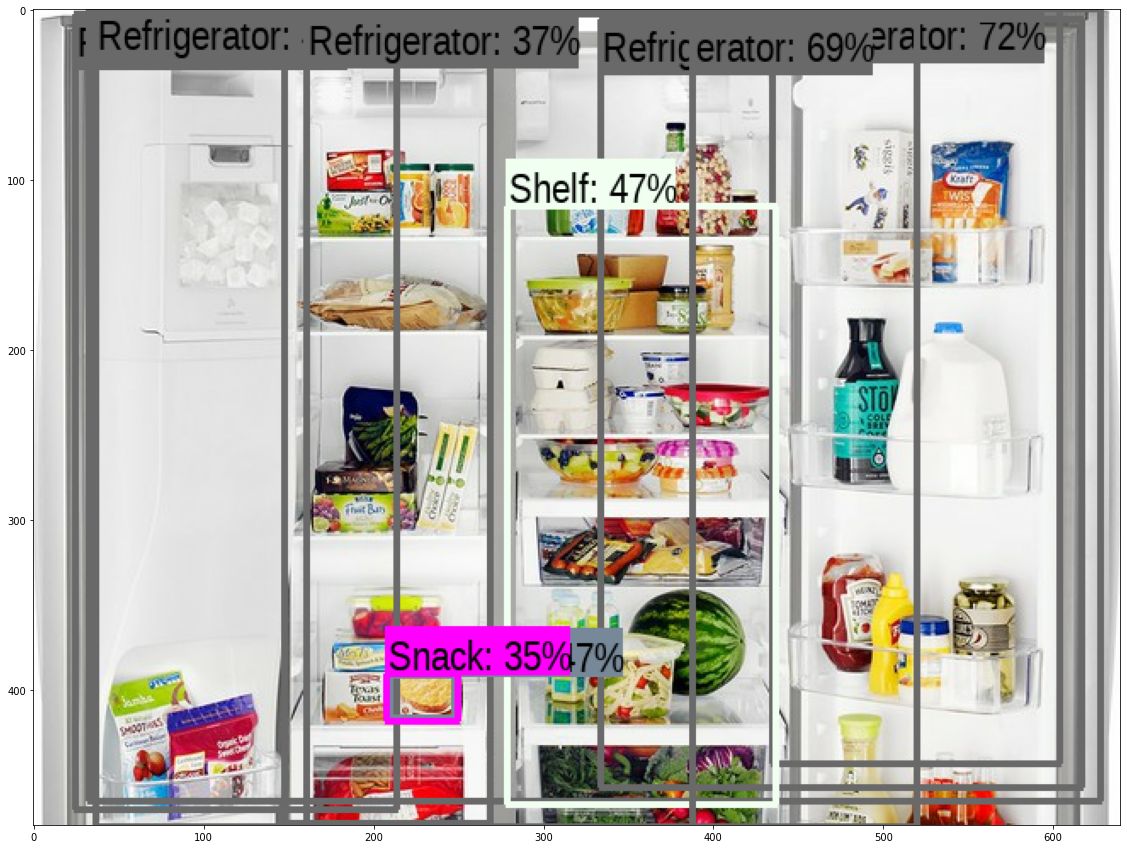

In [15]:
detect_img(image_urls[0])

Image downloaded to /tmp/tmp3f7ommeu.jpg.
Found 100 objects.
Inference time:  1.2144646644592285
Inference time: 1.7753558158874512


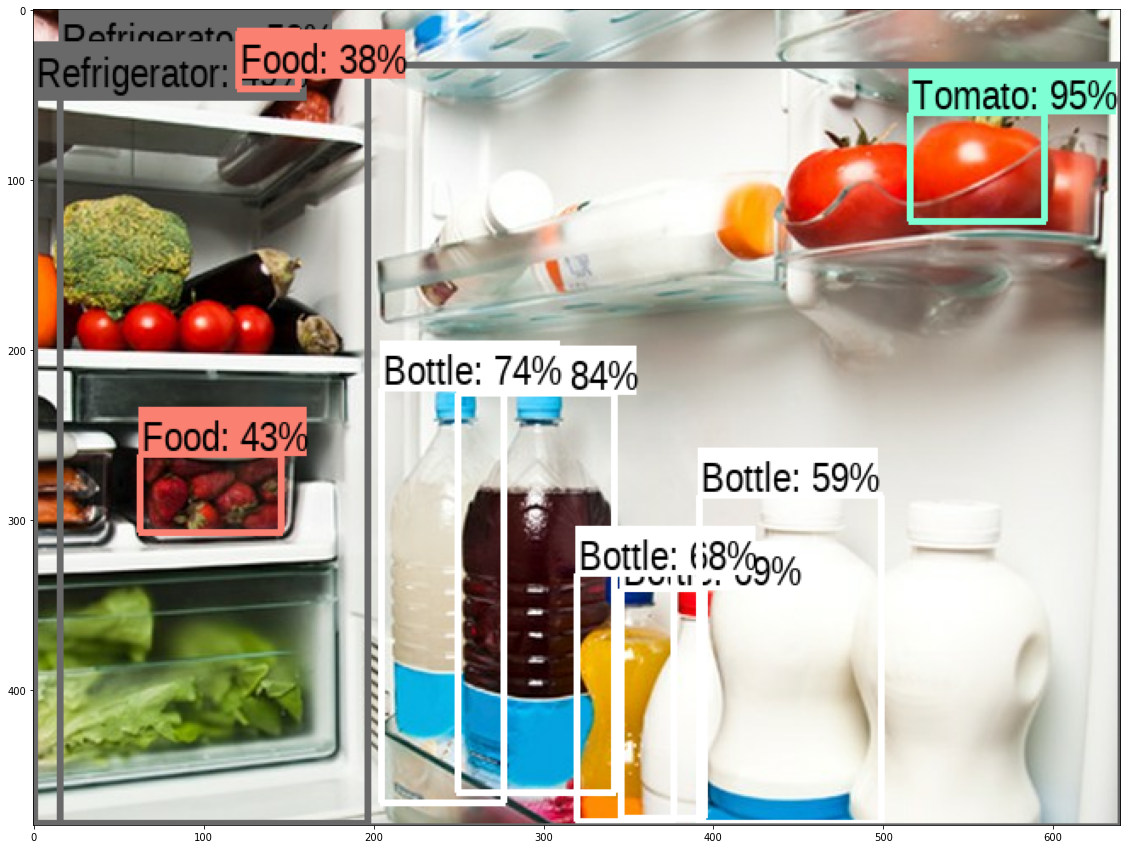

In [16]:
detect_img(image_urls[1])

Image downloaded to /tmp/tmpp2yycj4d.jpg.
Found 100 objects.
Inference time:  1.2196180820465088
Inference time: 1.4373562335968018


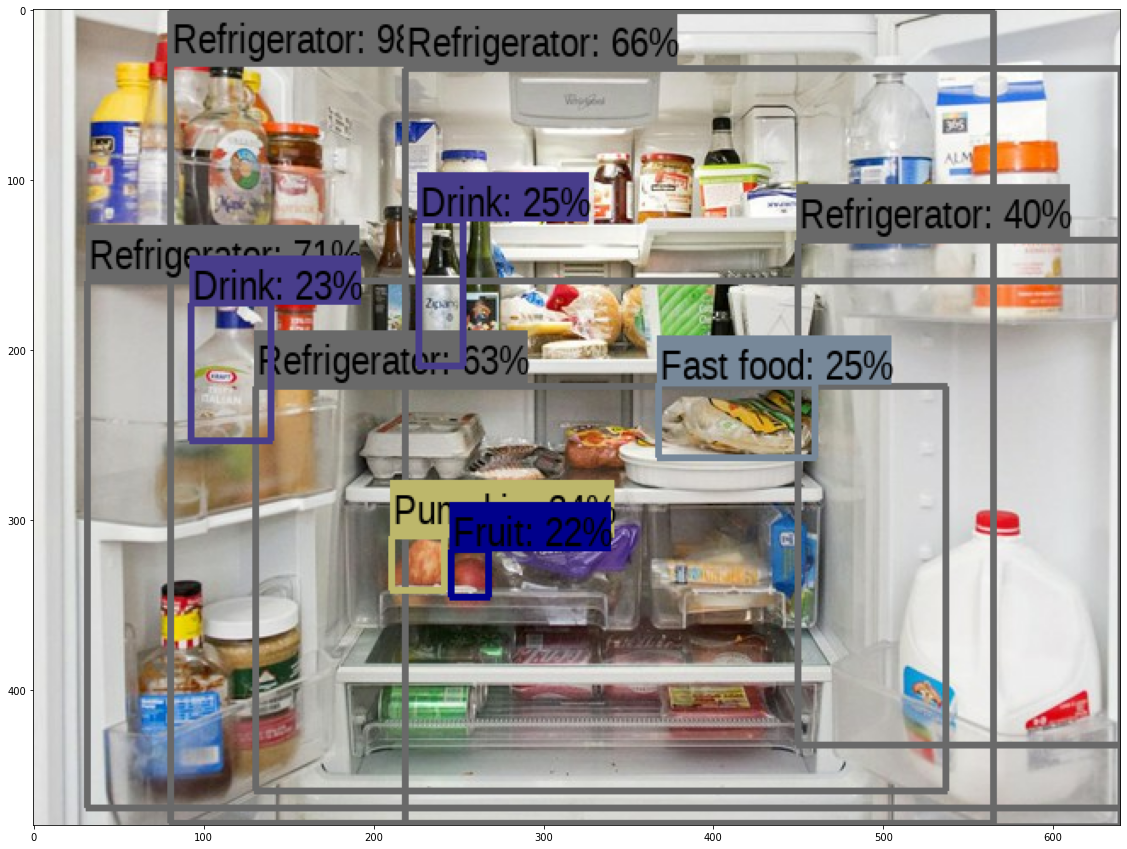

In [19]:
detect_img(image_urls[2])

Image downloaded to /tmp/tmpvi08a3x6.jpg.
Found 100 objects.
Inference time:  1.20646333694458
Inference time: 1.4695494174957275


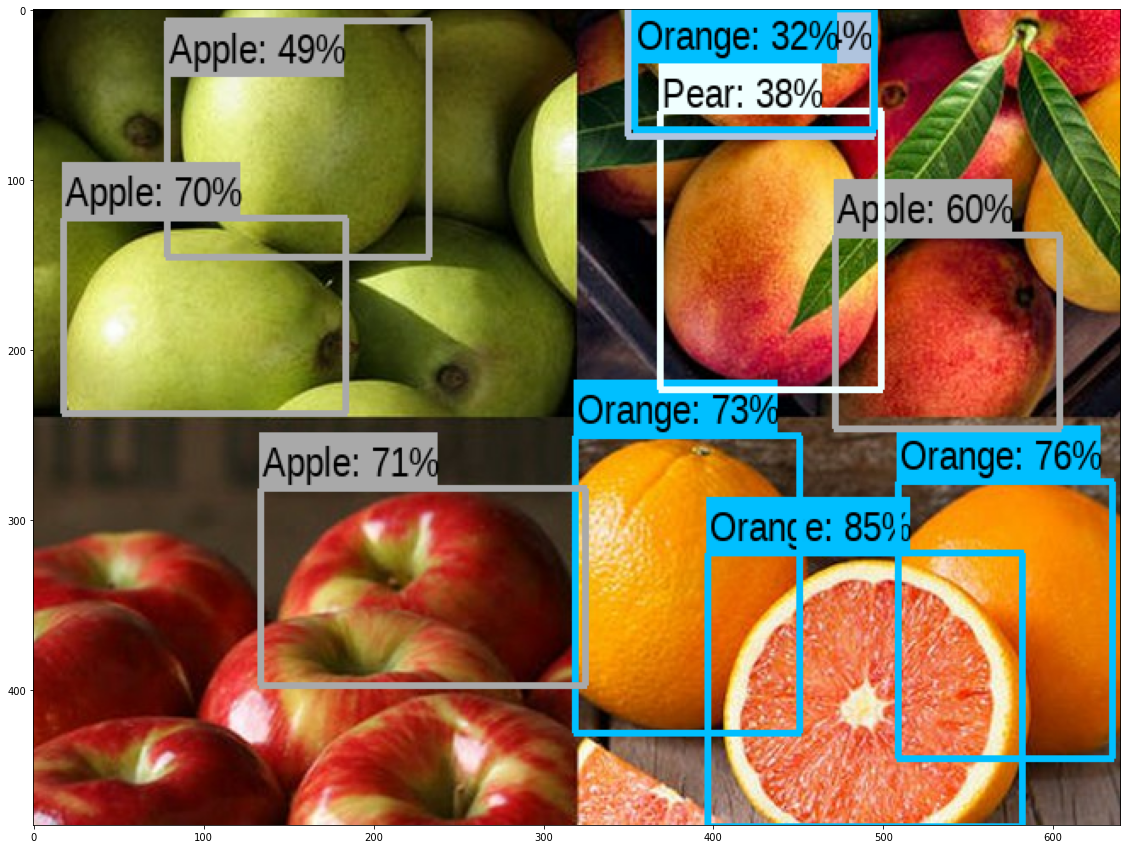

In [20]:
detect_img(image_urls[3])

Image downloaded to /tmp/tmplomei7xn.jpg.
Found 100 objects.
Inference time:  1.235644817352295
Inference time: 1.4973459243774414


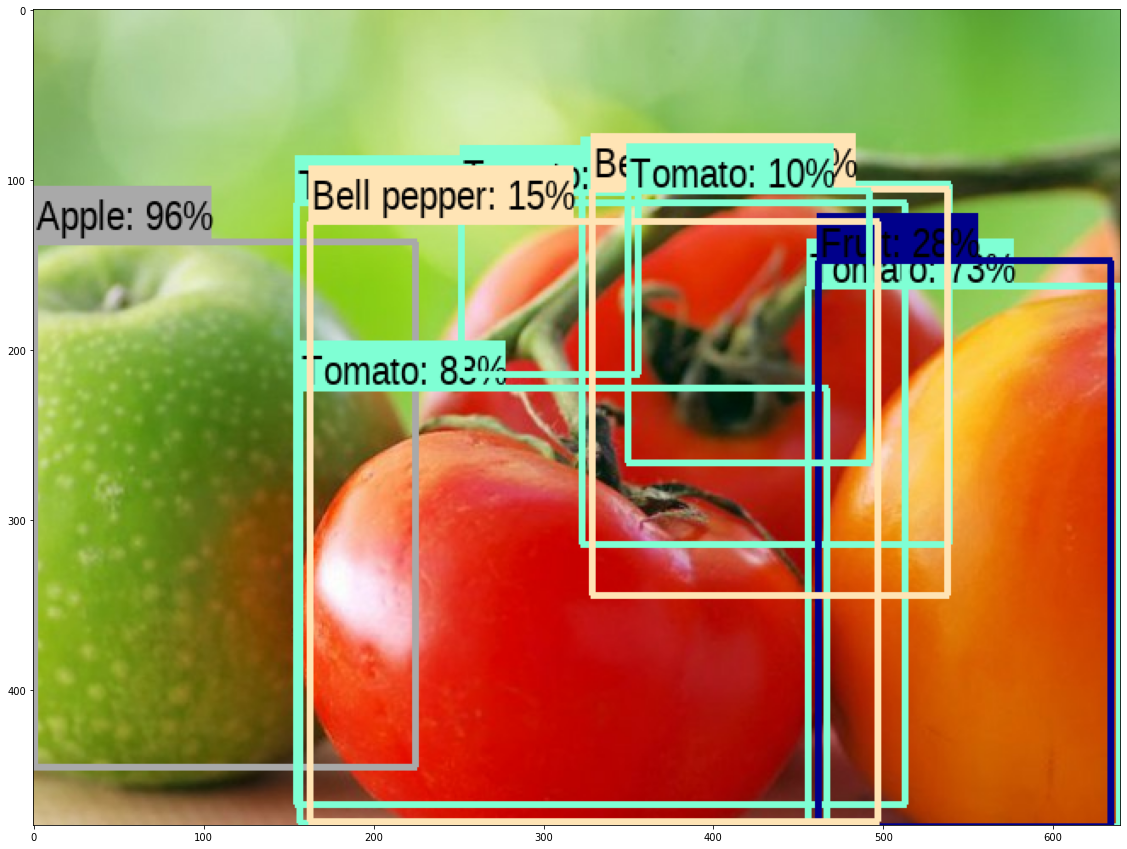

In [23]:
detect_img(image_urls[4])

Image downloaded to /tmp/tmpgx13nhfq.jpg.
Found 100 objects.
Inference time:  1.2298321723937988
Inference time: 1.315303087234497


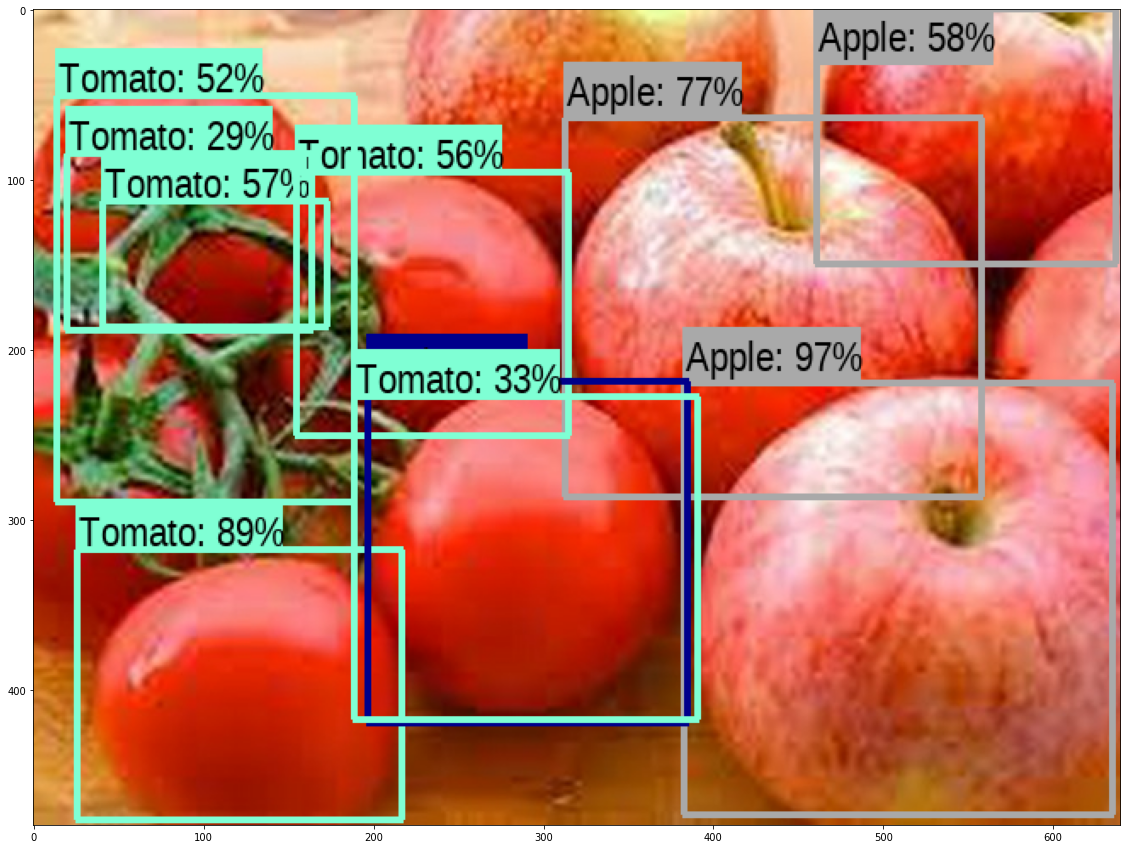

In [25]:
detect_img(image_urls[5])